<a href="https://colab.research.google.com/github/FerreiraVini/Diamonds/blob/main/Diamonts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diamonds**

Analyze diamonds by their cut, color, clarity, price, and other attributes


Context
This classic dataset contains the prices and other attributes of almost 54,000 diamonds.

Content
price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

#Import libraries

In [1]:
#for data import
import zipfile
from google.colab import drive
from google.colab import files

#for df handling and graph plots
import pandas as pd
import numpy as np
!pip install tqdm
from tqdm import tqdm
import seaborn as sns
import re
import matplotlib.pyplot as plt
import math
from itertools import combinations
from itertools import product

#for statistical models
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as ltb
from xgboost import XGBRegressor

#for model evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
!pip install shap lightgbm
import shap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data import and initial data information

In [2]:
drive.mount('/content/gdrive')

chunksize = 10000 #def the chunksize
n_chunks = int((sum(1 for row in open ('/content/gdrive/MyDrive/Data analysis - study/Diamonds/diamonds.csv', 'r')))/chunksize) #checking the number of chunks, rounding for int value.
print('Number of chunks = ', n_chunks)
fraction = 1/n_chunks
print('Fraction sampled from each chunk = ', fraction)

df_iterator = pd.read_csv('/content/gdrive/MyDrive/Data analysis - study/Diamonds/diamonds.csv', chunksize = chunksize)
counter = 0  # contador
for chunk in tqdm(df_iterator, total=(n_chunks)):
    if counter == 0:
        df = chunk.sample(frac=fraction, random_state = 44) #getting the same proportion of data from each chunk
    else:
        df_aux = chunk.sample(frac=fraction, random_state = 44)
        df = pd.concat([df,df_aux], axis=0)
    if df.shape[0] >= chunksize:
        break
    counter += 1
df = df.reset_index(drop=True)
df = df.drop(df.columns[0], axis='columns')
print('\n', 'df length = ', len(df),'\n')
print('df head:')
print(df.head())
print('\n')
print('df description')
print(df.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99 ]))
print('\n')
print('df info')
print(df.info())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Number of chunks =  5
Fraction sampled from each chunk =  0.2


 80%|████████  | 4/5 [00:00<00:00, 67.71it/s]


 df length =  10000 

df head:
   carat        cut color clarity  depth  table  price     x     y     z
0   0.76  Very Good     G    VVS2   61.5   59.0   3394  5.83  5.91  3.61
1   1.02  Very Good     J     SI2   62.9   59.0   3755  6.34  6.41  4.01
2   1.09      Ideal     J     SI1   60.7   58.0   4611  6.64  6.68  4.04
3   1.03  Very Good     F     SI2   60.2   55.0   3903  6.53  6.59  3.95
4   0.90  Very Good     D     SI1   62.8   59.0   4466  6.12  6.18  3.86


df description
              carat         depth         table         price             x  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.811628     61.747840     57.432350   4100.742200      5.748925   
std        0.495757      1.432299      2.206691   4177.862649      1.164968   
min        0.200000     44.000000     43.000000    337.000000      0.000000   
1%         0.240000     57.900000     53.000000    431.000000      4.010000   
5%         0.300000     59.300000     5

#Data overview

In [3]:
(df==0).any(axis=0)

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x           True
y           True
z           True
dtype: bool

In [4]:
(df=='nan').any(axis=0)

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

No NaN values, but some samples shows 0 in x,y,z coordinates. 
As a 3D object, that is highly improbable, so lets consider an error and drop such samples.

For that, I will consider the percentile 0.01 and 0.99 as thresholds, so we drop not only zeros, but also the most extreme values.

In [5]:
min = 1
max = 99
x_min = np.percentile(df['x'], min)
x_max = np.percentile(df['x'], max)
y_min = np.percentile(df['y'], min)
y_max = np.percentile(df['y'], max)
z_min = np.percentile(df['z'], min)
z_max = np.percentile(df['z'], max)

df=df.drop(df[(df['x'] > x_max)].index)
df=df.drop(df[(df['x'] < x_min)].index)
df=df.drop(df[(df['y'] > y_max)].index)
df=df.drop(df[(df['y'] < y_min)].index)
df=df.drop(df[(df['z'] > z_max)].index)
df=df.drop(df[(df['z'] < z_min)].index)

df.reset_index()
df.head()

carat        cut color clarity  depth  table  price     x     y     z
0   0.76  Very Good     G    VVS2   61.5   59.0   3394  5.83  5.91  3.61
1   1.02  Very Good     J     SI2   62.9   59.0   3755  6.34  6.41  4.01
2   1.09      Ideal     J     SI1   60.7   58.0   4611  6.64  6.68  4.04
3   1.03  Very Good     F     SI2   60.2   55.0   3903  6.53  6.59  3.95
4   0.90  Very Good     D     SI1   62.8   59.0   4466  6.12  6.18  3.86

In [6]:
def single_var(df, col):
  if df[col].dtypes != 'object':
    df[col].hist(bins=20)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Distribution of ' + col)
       
  else:
    df.groupby(df[col])[col].count().plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Distribution of ' + col)


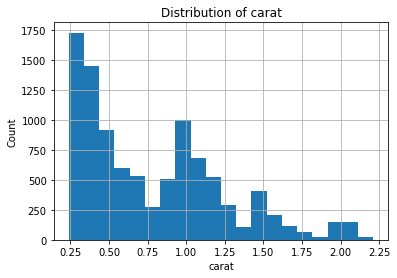

In [7]:
single_var(df, 'carat')

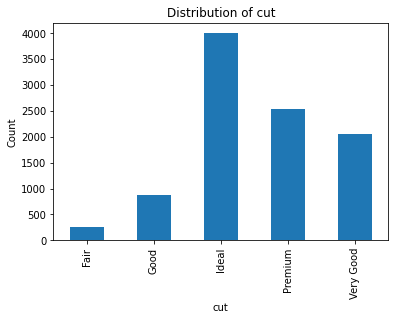

In [8]:
single_var(df, 'cut')

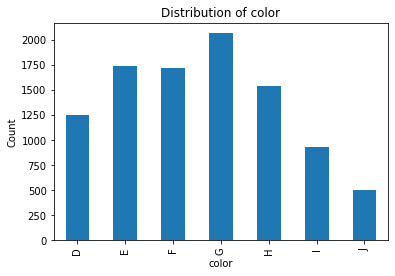

In [9]:
single_var(df, 'color')

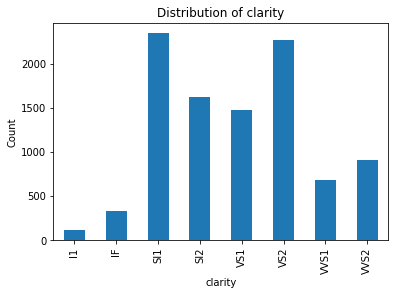

In [10]:
single_var(df, 'clarity')

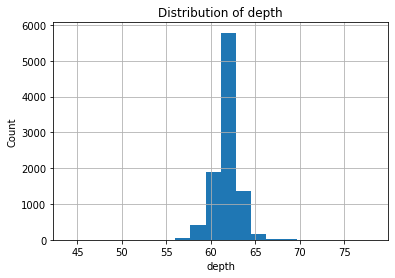

In [11]:
single_var(df, 'depth')

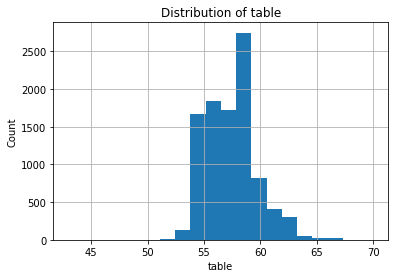

In [12]:
single_var(df, 'table')

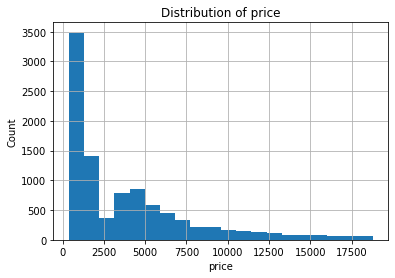

In [13]:
single_var(df, 'price')

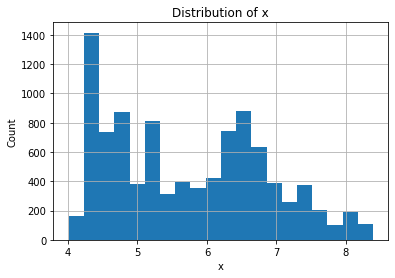

In [14]:
single_var(df, 'x')

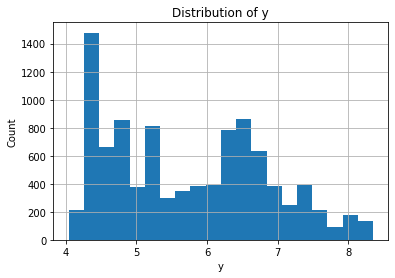

In [15]:
single_var(df, 'y')

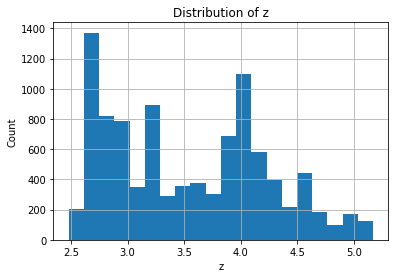

In [16]:
single_var(df, 'z')

Now we have a df with no missing or extreme values.

Note that Carat distributions seems to follow a pattern.

At price 2500 we have a strange drop in counts. For some reason seems to be more dificult to have diamonts of this specifical price

#Size, color, clarity and cut EDA

Initially, we could verify obvious correlations.
As we have a few categorical variables, we could do an encoding. For example, the cut quality, besides beeing categorical, has a quantitative information. The higher the quality, the better.

Clarity has a similar behaviour.

For the color we could do latter a dummy encoding for model buildup, but we could verify fist if we have a correlation between price and color.

In [17]:
#transforming cut and clarity in numerical data.
df['cut_quality'] = 0
for index, row in tqdm(df.iterrows()):
  if row['cut'] == 'Fair':
    quality = 1
  elif row['cut'] == 'Good':
    quality = 2
  elif row['cut'] == 'Very Good':
    quality = 3
  elif row['cut'] == 'Premium':
    quality = 4
  else:
    quality = 5
  df.at[index, 'cut_quality'] = quality
  
df['clarity_quality'] = 0
for index, row in tqdm(df.iterrows()):
  if row['clarity'] == 'I1':
    quality = 1
  elif row['clarity'] == 'SI2':
    quality = 2
  elif row['clarity'] == 'SI1':
    quality = 3
  elif row['clarity'] == 'VS2':
    quality = 4
  elif row['clarity'] == 'VS1':
    quality = 5
  elif row['clarity'] == 'VVS2':
    quality = 6
  elif row['clarity'] == 'VVS1':
    quality = 7
  else:
    quality = 8
  df.at[index, 'clarity_quality'] = quality
df = df.drop(['cut', 'clarity'], axis='columns')

9733it [00:00, 16707.73it/s]
9733it [00:01, 8672.45it/s]


In [18]:
#verifying the correlations
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

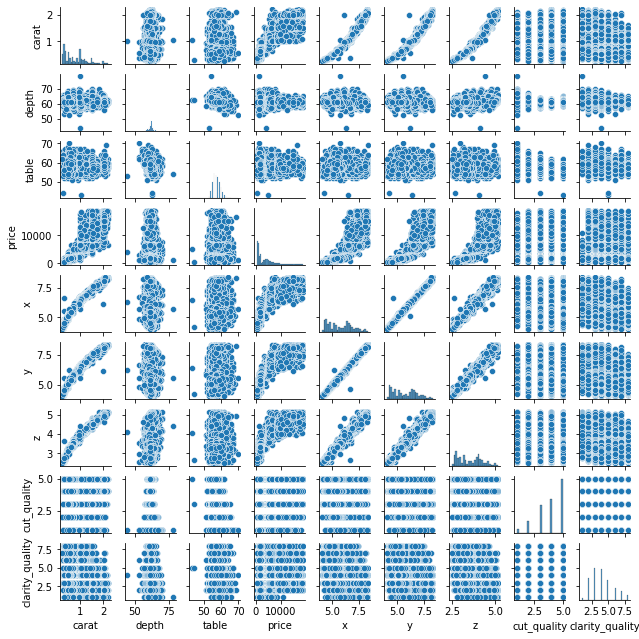

In [19]:
sns.pairplot(data=df, height=1)
plt.show()

Price and size relative columns are obviously correlated.
Color, cut quality and clarity quality aparently has no direct effect in price. However, could be that between diamonts of similar size, color, cut and clarity have an effect.

For a better evaluation and visualization lets separate the samples by carat percentile, and see if in between each group of size, we have an effect of cut and clarity quality in price.

In [20]:
#generating a new feature based in size quartile.
threshold_1 = 25
threshold_2 = 50
threshold_3 = 75
first_per = np.percentile(df['carat'], threshold_1)
second_per = np.percentile(df['carat'], threshold_2)
third_per = np.percentile(df['carat'], threshold_3)

df['size_quartile'] = 0
for index, row in tqdm(df.iterrows()):
  if row['carat'] <= first_per:
    size = 1
  elif row['carat'] <= second_per:
    size = 2
  elif row['carat'] <= third_per:
    size = 3
  elif row['carat'] > third_per:
    size = 4
  df.at[index, 'size_quartile'] = size

9733it [00:00, 18399.89it/s]


In [21]:
def boxplot(x, y, quartile, ax):
   if quartile == 'none':
    sns.boxplot(x=x, y=y, order=('G', 'J', 'F', 'D', 'E', 'H', 'I'),data=df, ax=ax)
    ax.set_title('Size distribution by color')
   else:
    sns.boxplot(x=x, y=y, order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df.query(f'size_quartile == {quartile}'), ax=ax)
    ax.set_title(f'Size distribution, in quartile "{quartile}", by color')

def barplot_var(x, y, hue, ax):
  if hue != 'none':
    sns.barplot(x=x, y=y, hue=hue, data=df, estimator=np.mean, ax=ax)
    ax.set_title(f'{y} distribution per {x} and {hue}')
  else:
    sns.barplot(x=x, y=y, data=df, estimator=np.mean, ax=ax)
    ax.set_title(f'{y} distribution per {x}')

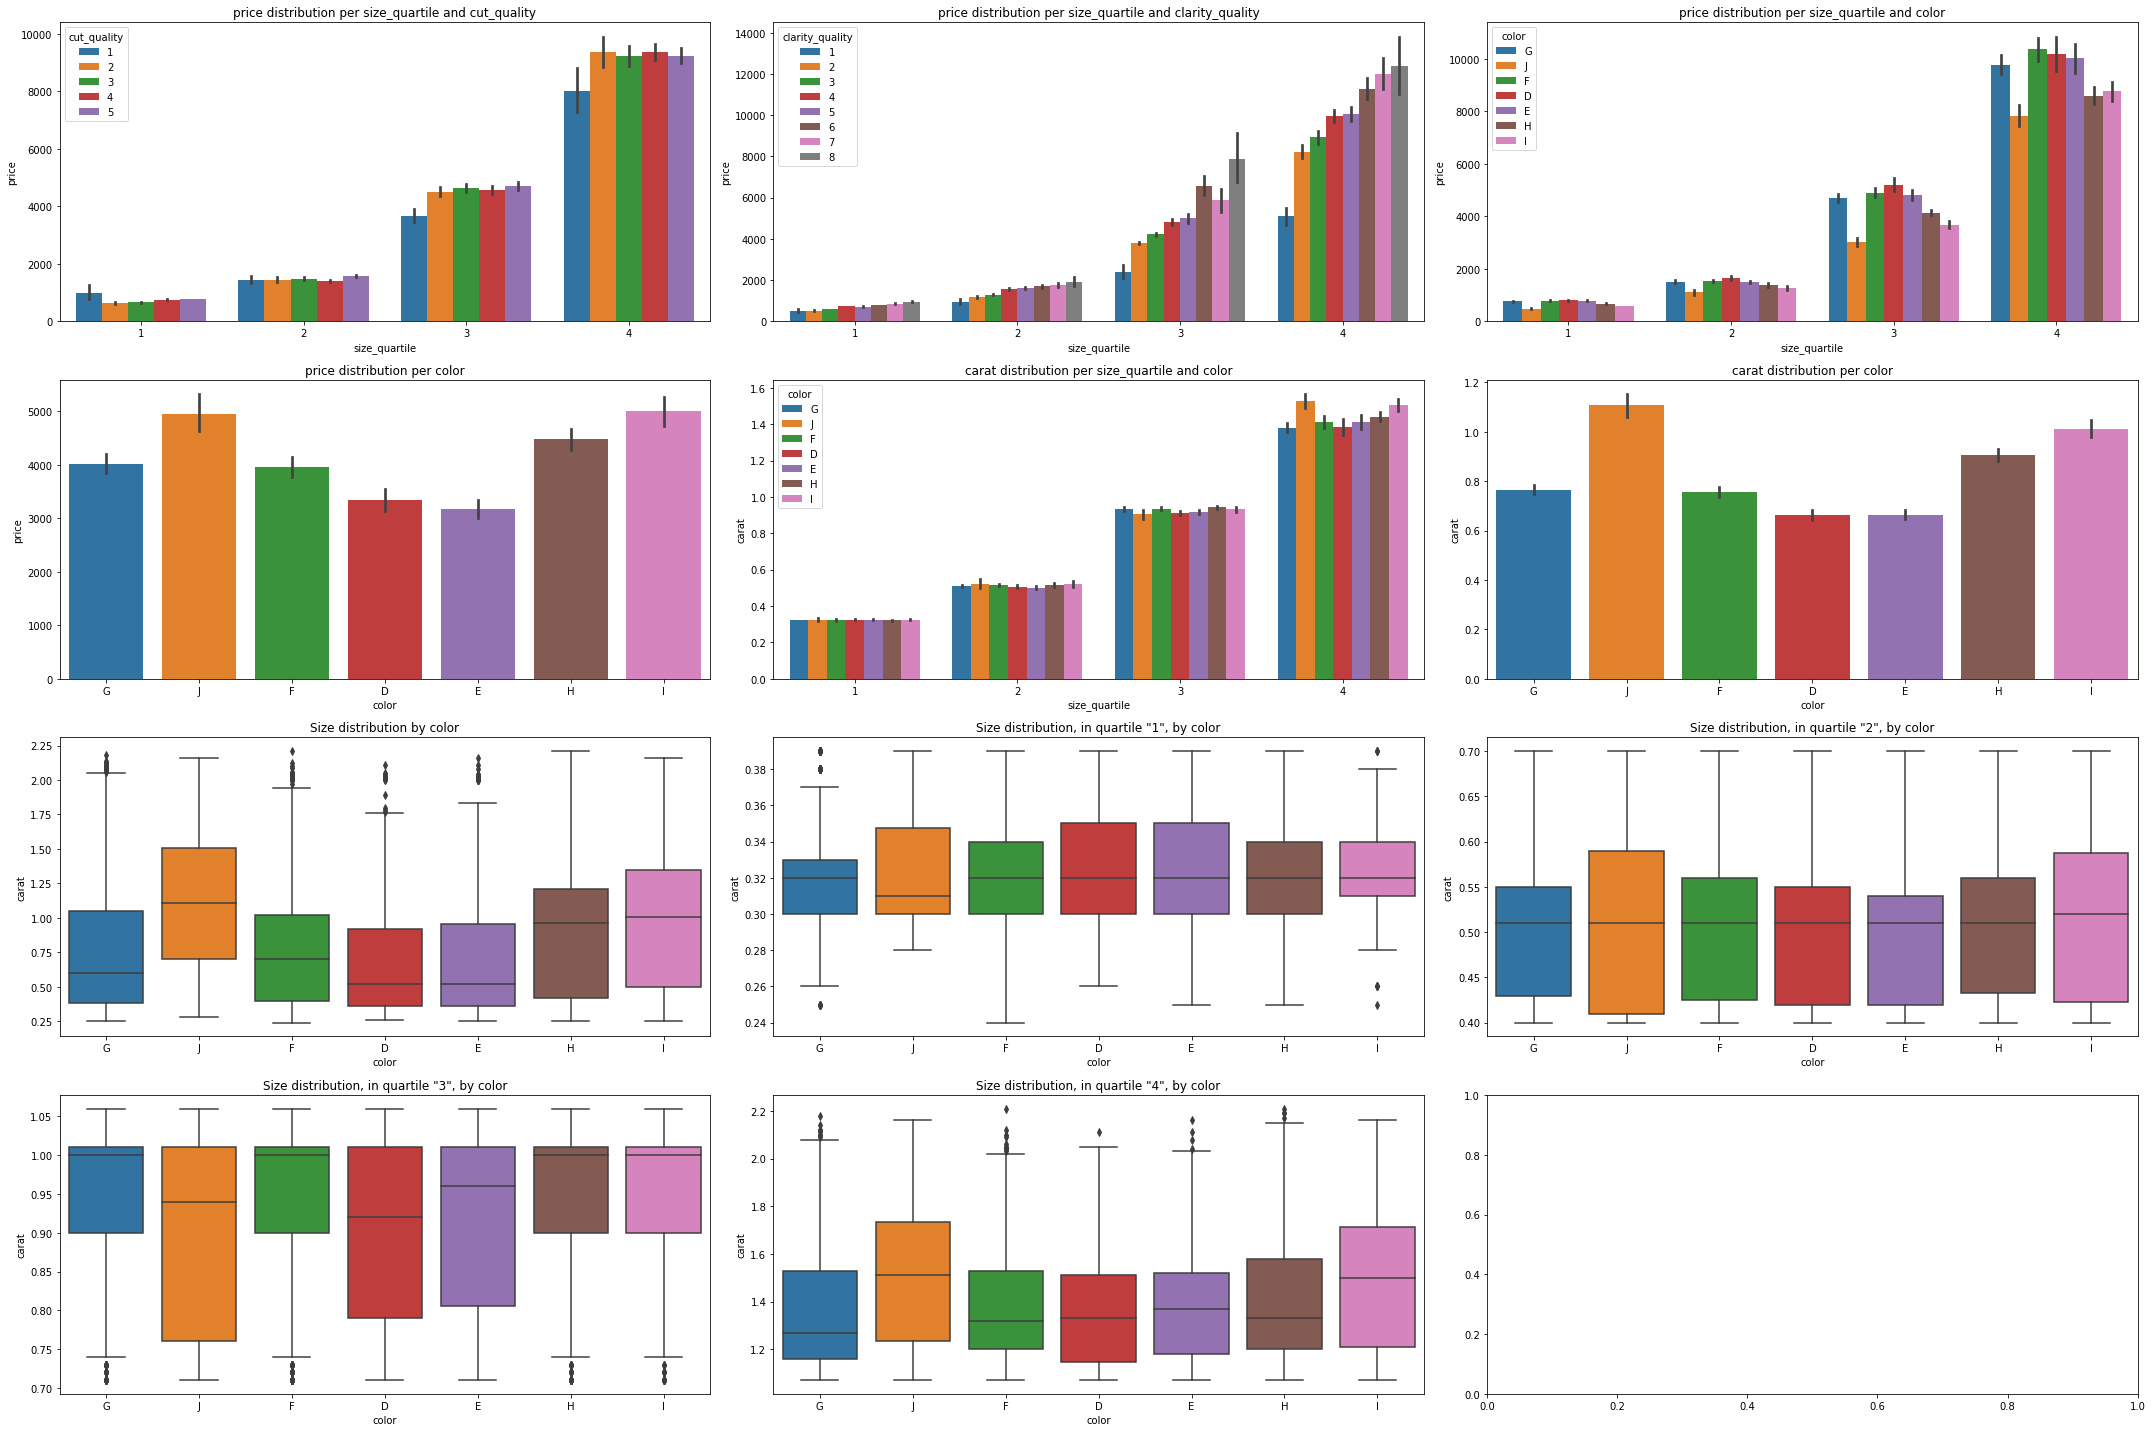

In [22]:
#verifying correlation between price and cut, color and clarity in similar sized diamonds.
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(30,20))

barplot_var('size_quartile', 'price', 'cut_quality', ax1)
barplot_var('size_quartile', 'price', 'clarity_quality', ax2)
barplot_var('size_quartile', 'price', 'color', ax3)
barplot_var('color', 'price', 'none', ax4)
barplot_var('size_quartile', 'carat', 'color', ax5)
barplot_var('color', 'carat', 'none', ax6)
boxplot('color', 'carat', 'none', ax7)
boxplot('color', 'carat', 1, ax8)
boxplot('color', 'carat', 2, ax9)
boxplot('color', 'carat', 3, ax10)
boxplot('color', 'carat', 4, ax11)

plt.tight_layout()
plt.show()

From the above graphs:

- Almost no price gain for overall cut_quality (despite a lower price for poor cut)
- high effect of clarity on price, particularly for bigger diamonds.
- Some colors shows lower prices. But that could be due to different sample distribution between colors, such as different sizes and clarity.

- J shows the lowest price average in higher quartiles, but when looking for color average price, J has one of the highest. That is probably due to J size distribution. It probably has a higher average size, so the prices tend to be higher. The graph of size distribution (overal and per quartiles) enforces this theory.

- D and E have the lowest average prices per color, and we can see that those colors have a lower average diamond size.

Therefore, a good measure would be price/carat, correcting the size effect on price.

In [23]:
def price_carat_color (color_type):
  new_df = df.query(f'color == "{color_type}"')
  price_carat = round((new_df['price'].sum())/new_df['carat'].sum(), 2)
  return(price_carat)

In [24]:
price_carat_color_comparison = {'Color': ['D','E', 'F', 'G', 'H', 'I', 'J'], 'price/carat/color#': [price_carat_color('D'), price_carat_color('E'), price_carat_color('F'), price_carat_color('G'),
                                                                                                    price_carat_color('H'), price_carat_color('I'), price_carat_color('J')]}
price_carat_color_comparison_df = pd.DataFrame(price_carat_color_comparison).set_index('Color')
print(price_carat_color_comparison_df)

       price/carat/color#
Color                    
D                 5038.30
E                 4786.25
F                 5235.82
G                 5254.44
H                 4933.68
I                 4939.06
J                 4474.98


- as expected, J has the lowest average price/size.
- H and I shows similar prices, but a bit higher than J, which is expected, as they have similar average price, but lower average size.
- F and G shows the highest price/size, which is expected, as they have high average prices and low average sizes.
- E has the second lowest price/size, which is also expected, since it has a low average price and low average size.
- D, however, has a higher price/size than E, besides a similar behaviour in average price and average size as E.

A possible explanation of D behaviour would be concearning the clarity.

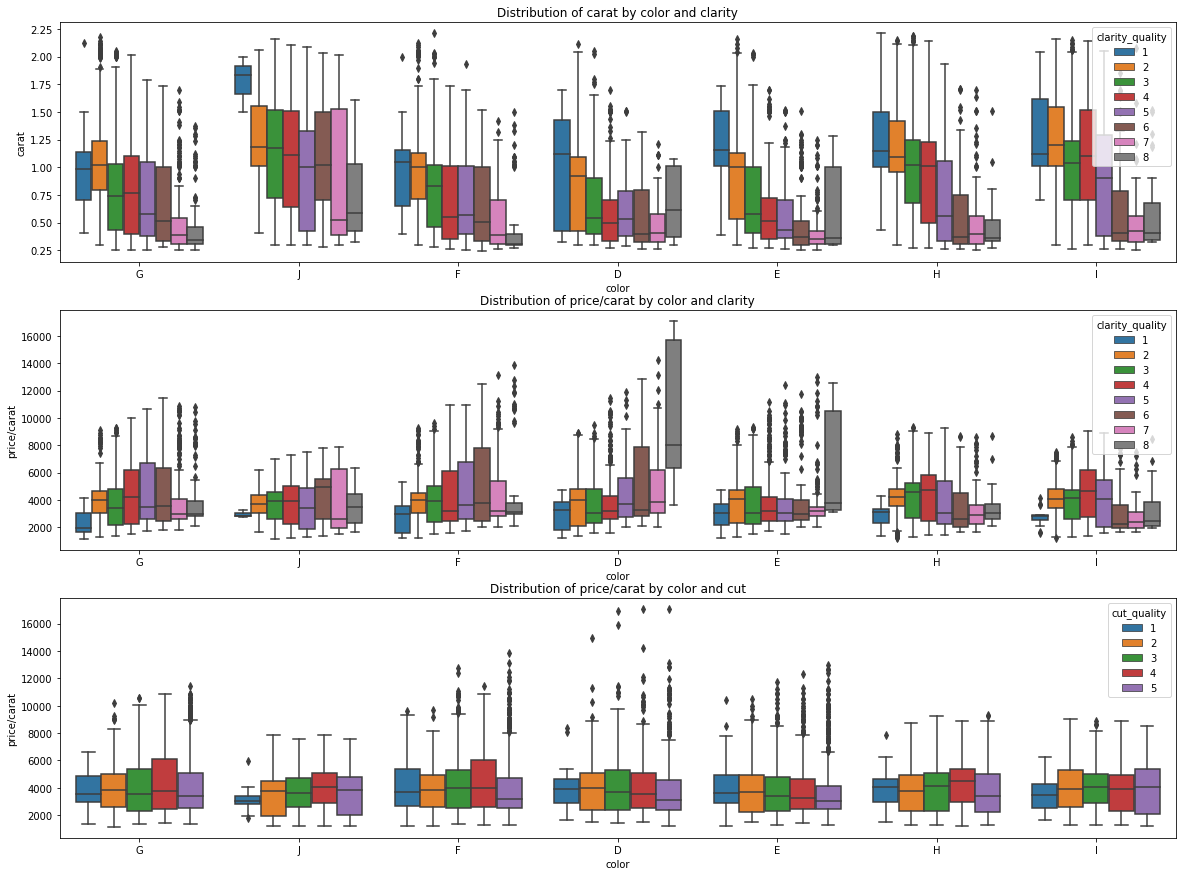

In [25]:
df2=df.copy()
df2['price/carat'] = round((df2['price'])/df2['carat'], 2)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,15))

sns.boxplot(x='color', y='carat', hue = 'clarity_quality', order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df2, ax=ax1)
ax1.set_title('Distribution of carat by color and clarity')

sns.boxplot(x='color', y='price/carat', hue = 'clarity_quality', order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df2, ax=ax2)
ax2.set_title('Distribution of price/carat by color and clarity')

sns.boxplot(x='color', y='price/carat', hue = 'cut_quality', order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df2, ax=ax3)
ax3.set_title('Distribution of price/carat by color and cut')

plt.show()

As expected, clarity has a higher effect in diamonds of color D than on E.
Additionally, diamonds of color D may have a higher number of high clarity than the others.

In [26]:
def clarity_color(color_type, ax):
  newdf = df.query(f'color == "{color_type}"')
  sns.countplot(x='clarity_quality', data=newdf, ax=ax)
  ax.set_title(f'Clarity quality count for color = "{color_type}"')

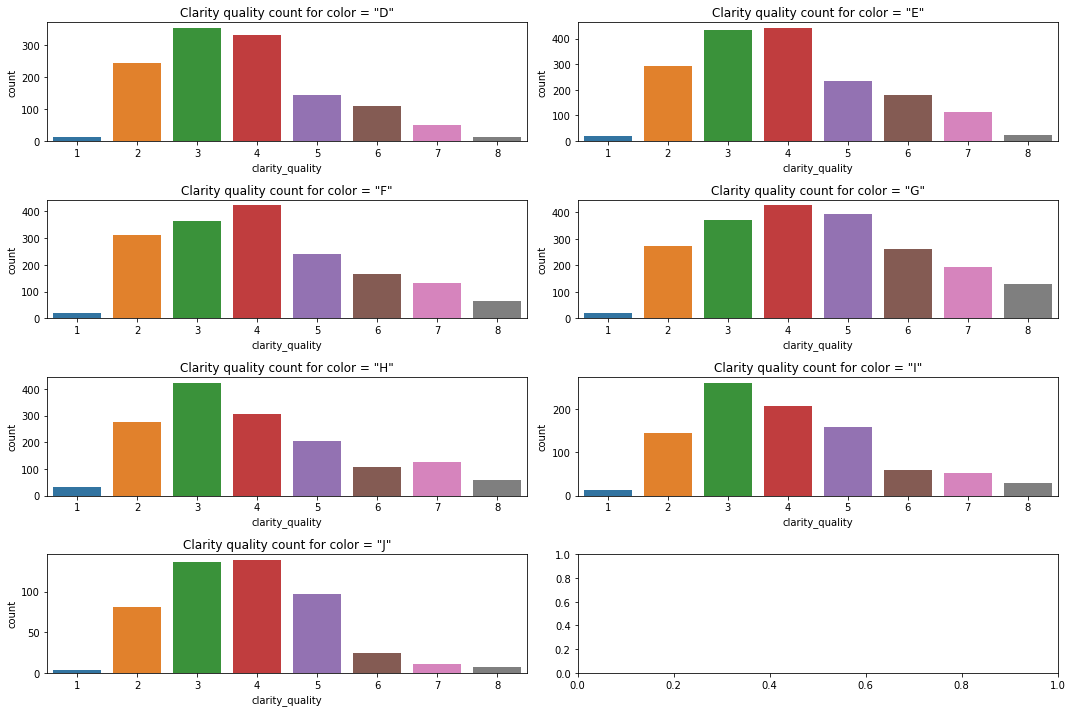

In [27]:
fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))
clarity_color('D', ax)
clarity_color('E', ax2)
clarity_color('F', ax3)
clarity_color('G', ax4)
clarity_color('H', ax5)
clarity_color('I', ax6)
clarity_color('J', ax7)

plt.tight_layout()
plt.show()

- color D and E has a similar number of high clarity diamonds. So the higher average price/size of D diamonds, and the higher average price/size of color D and high clarity can only be explained by a higher market value. Perhaps associated with buyers preference, instead of a demand/offer question.

- G color has higher proportion of high clarity diamonds. Therefore, as G and F have a similar average price/size, the overall market value of clear G diamonds is slightly lower than diamonds F.

That means a good feature would be calculate the average price per size, per color and per clarity, and attribute for each diamond the average price per size acordingly to its color and clarity. this tends to be more accurate than simply price/size calculation.

In [28]:
def price_carat_color_and_clarity (color_type, clarity_type):
  new_df = df.query(f'color == "{color_type}"')
  new_df2 = new_df.query(f'clarity_quality == {clarity_type}')
  price_carat_color_clarity = round((new_df2['price'].sum())/new_df2['carat'].sum(), 2)
  return(price_carat_color_clarity)

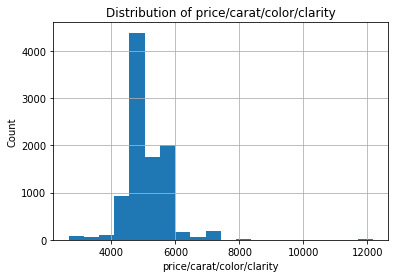

In [29]:
df['price/carat/color/clarity'] = df.apply(lambda row: price_carat_color_and_clarity(color_type=row['color'], clarity_type=row['clarity_quality']), axis=1)
single_var(df, 'price/carat/color/clarity')

Now we have a feature that corresponds to average market value based on size, color and clarity.

Note that the highest value of this features stands for diamonds color D and clarity 8, with value of > 12,000.00 dollars per carat, 30% more than the second highest price.

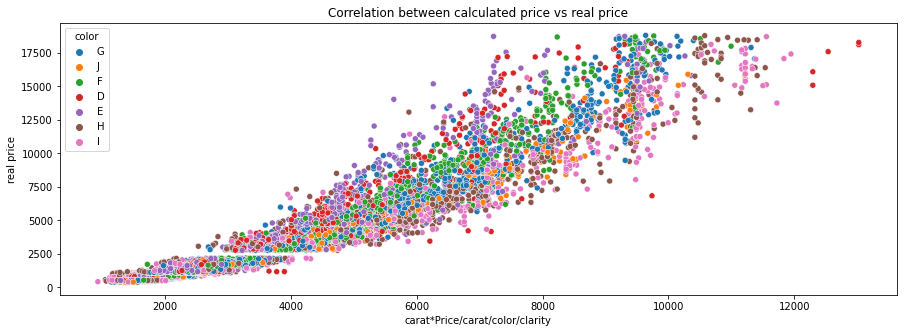

In [30]:
fig, (ax1) = plt.subplots(1, figsize=(15,5))
sns.scatterplot(x=df['carat']*df['price/carat/color/clarity'], y=df['price'], hue='color', data=df, ax=ax1)
ax1.set_title('Correlation between calculated price vs real price')
ax1.set_xlabel('carat*Price/carat/color/clarity')
ax1.set_ylabel('real price')
plt.show()

- just with this feature we have already a fair correlation between real price and calculated based on this feature alone.

- we can create a feature based on those constants * carat, as we already have the constant and will have the carat of the diamond.

In [31]:
df['ccc_mean_price*carat'] = df['carat']*df['price/carat/color/clarity'] # ccc_mean_price stands for color, clarity, carat mean price - we may drop the constant now, since it was already used.

In [32]:
df = df.drop(['size_quartile', 'price/carat/color/clarity'], axis='columns') #we already have size information, and particioning the sizes was only useful for visualization, not useful for the model.

#Shape EDA

Another interesting aspect to evaluate would be the diamonds shape.

In [33]:
def scatter_plot(x, y, hue, ax):
  if hue != 'none':
    sns.scatterplot(x=x, y=y, hue=hue, data=df, ax=ax)
    ax.set_title(f' "y" distribution per {x} and {hue}')
    ax.set_ylabel(f'"y"')
    ax.set_xlabel(f'"{x}"')
  else:
    sns.scatterplot(x=x, y=y, data=df, ax=ax)
    ax.set_title(f'"y" distribution per {x}')
    ax.set_ylabel(f'"y"')
    ax.set_xlabel(f'"{x}"')

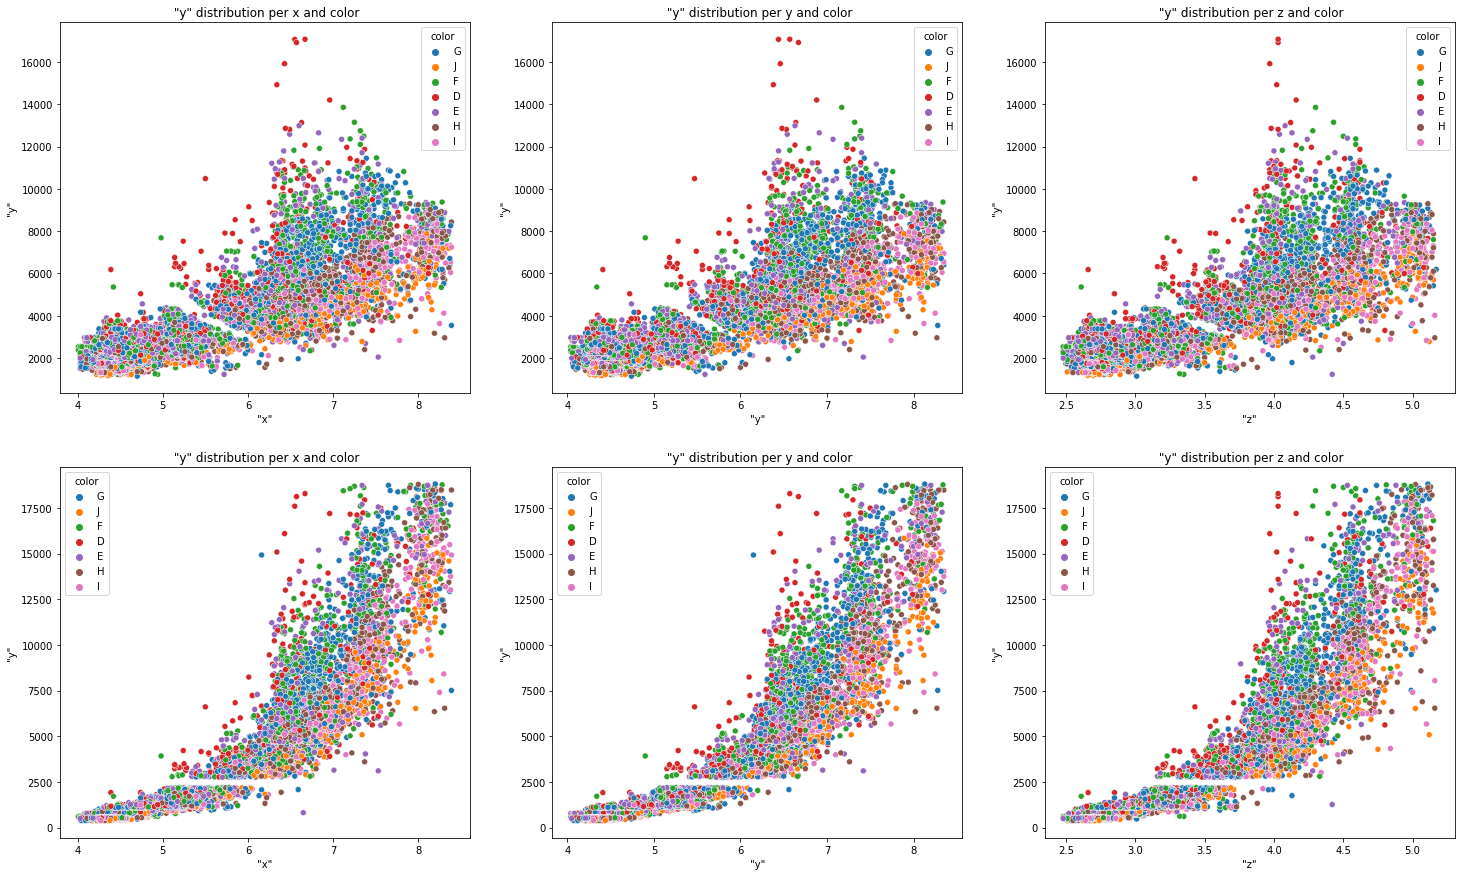

In [34]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25,15))
scatter_plot('x', df['price']/df['carat'], 'color', ax1)
scatter_plot('y', df['price']/df['carat'], 'color', ax2)
scatter_plot('z', df['price']/df['carat'], 'color', ax3)

scatter_plot('x', 'price', 'color', ax4)
scatter_plot('y', 'price', 'color', ax5)
scatter_plot('z', 'price', 'color', ax6)
plt.show()

The above graphs shows, again, that color and size is highly correlated to price. However, are shape of the diamonds relevant to price?

One initial way to evaluate this is to verify which diamonds are spherical and which is not, and see if is there a price correlation.

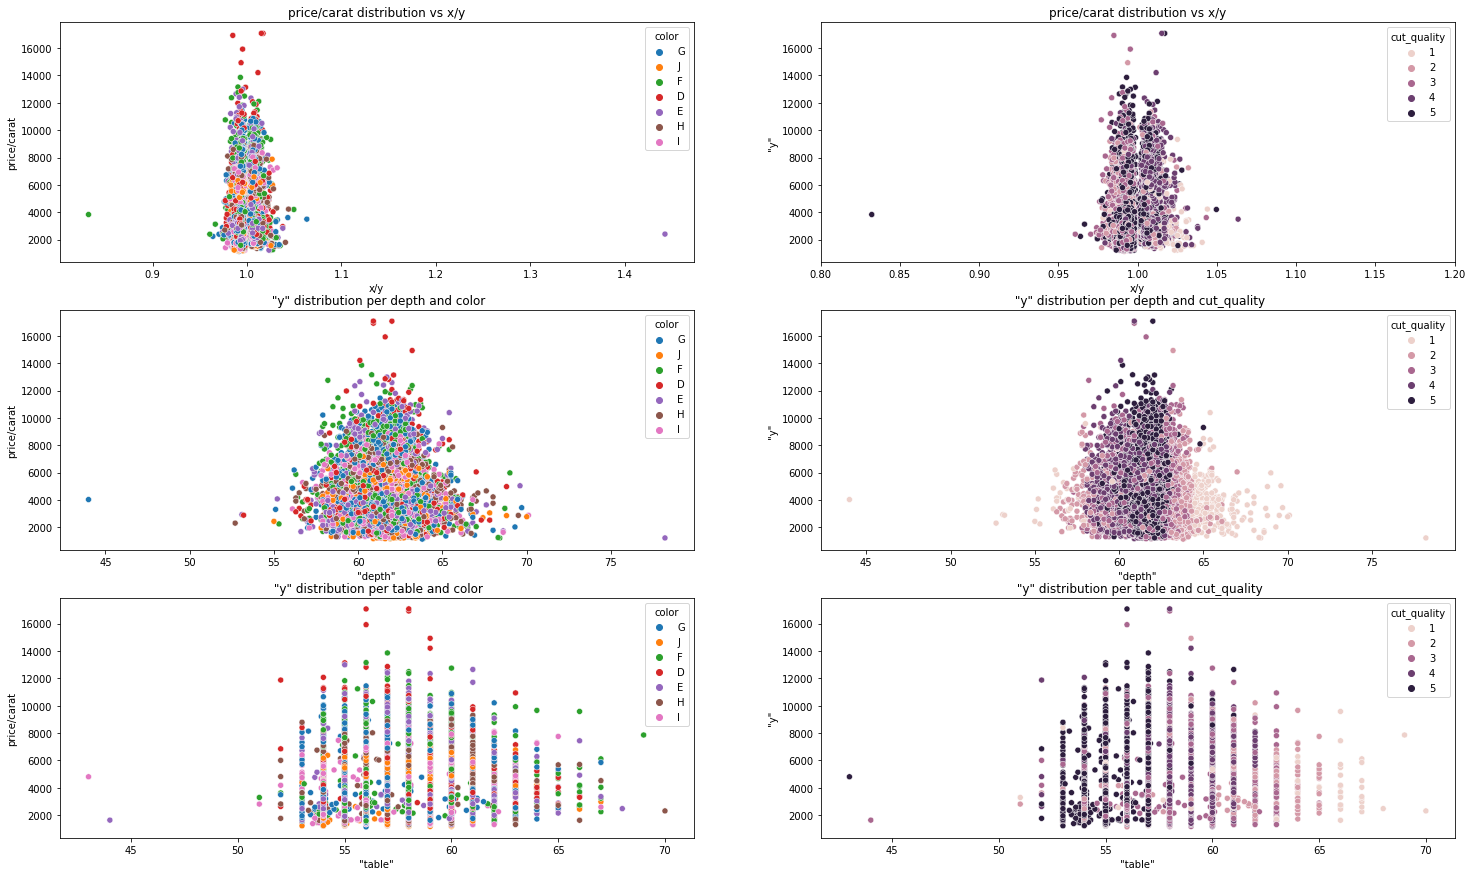

In [35]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(25,15))
scatter_plot(df['x']/df['y'], df['price']/df['carat'], 'color', ax1) #if the diamond is oval shaped, or retangular, x/y will be != 1.
ax1.set_xlabel('x/y')
ax1.set_ylabel('price/carat')
ax1.set_title('price/carat distribution vs x/y')

scatter_plot(df['x']/df['y'], df['price']/df['carat'], 'cut_quality', ax2)
ax2.set_xlim(0.8, 1.2)
ax2.set_xlabel('x/y')
ax2.set_title('price/carat distribution vs x/y')

scatter_plot('depth', df['price']/df['carat'], 'color', ax3)
ax3.set_ylabel('price/carat')

scatter_plot('depth', df['price']/df['carat'], 'cut_quality', ax4)

scatter_plot('table', df['price']/df['carat'], 'color', ax5)
ax5.set_ylabel('price/carat')

scatter_plot('table', df['price']/df['carat'], 'cut_quality', ax6)

plt.show()

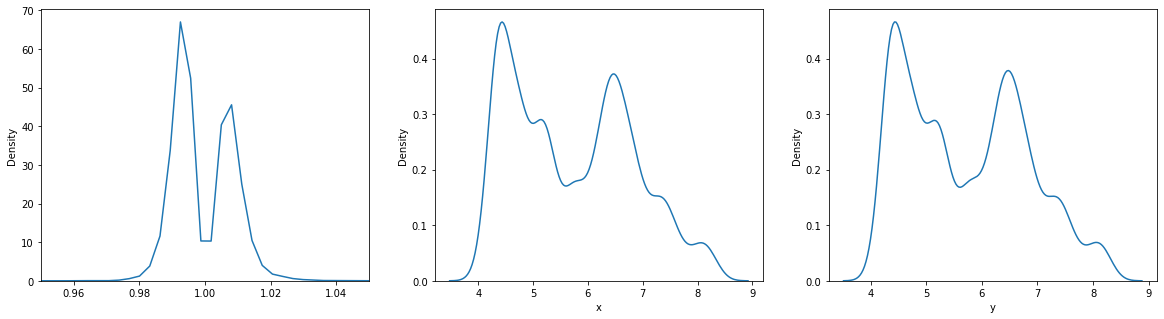

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

sns.kdeplot(x=df['x']/df['y'], ax=ax1)
ax1.set_xlim(0.95, 1.05)

sns.kdeplot(x=df['x'], ax=ax2)

sns.kdeplot(x=df['y'], ax=ax3)

plt.show()

There is no clear correlation between shape and diamond price. Cut quality is shown again to not be much impacting.

We do see a correlation between table, depth and cut quality, with price. all of them shows a better price in a specific range. 

- the KDE plots shows that all the diamonds have a spherical shape. Most of them are not PERFECLY circular, x/y = 1, but they are close to it.


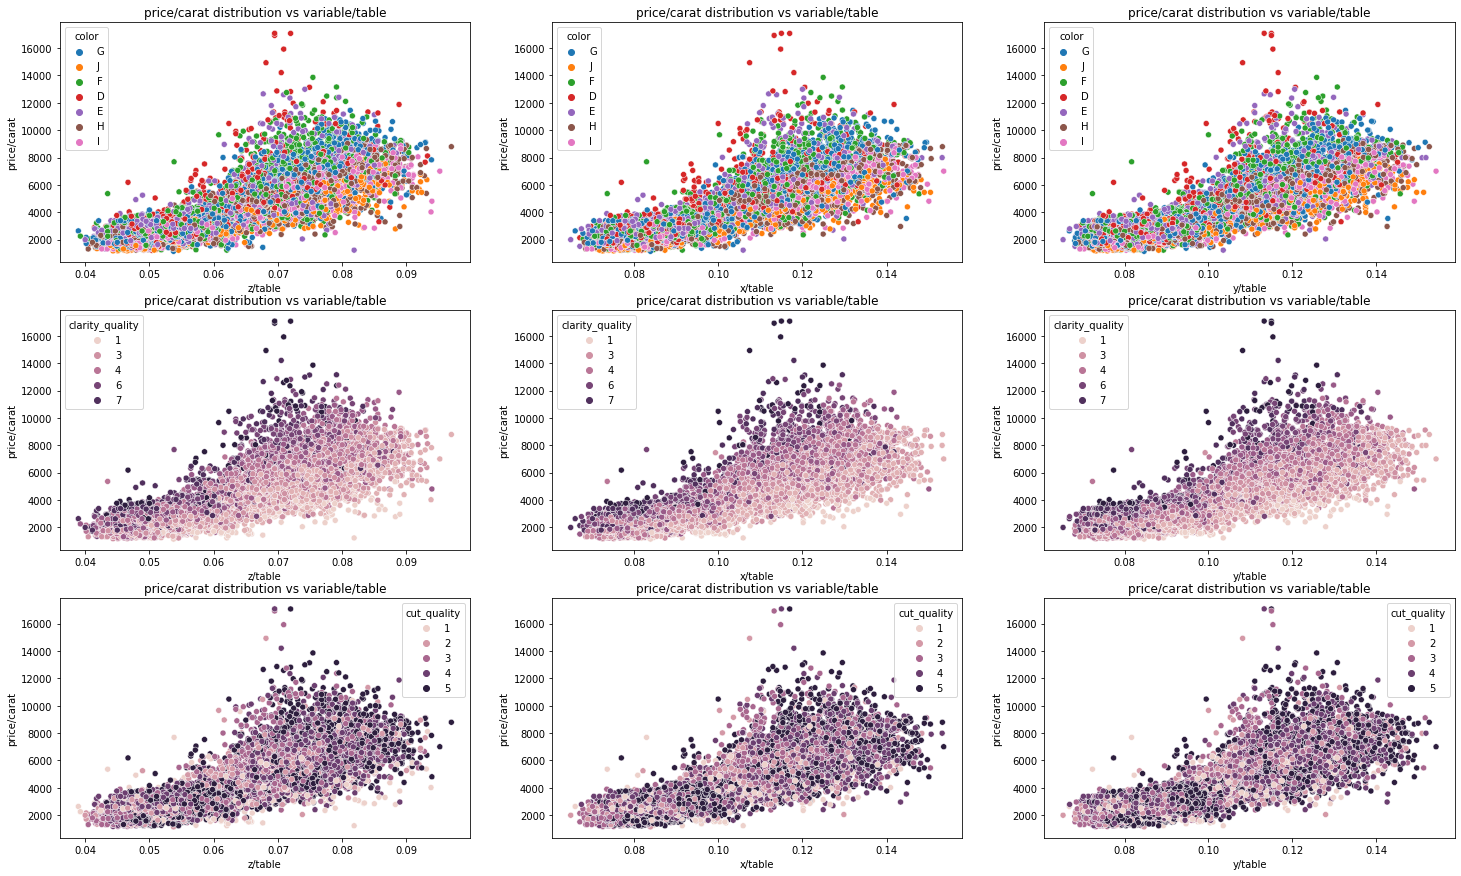

In [37]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(25, 15))
scatter_plot(df['z']/df['table'], df['price']/df['carat'], 'color', ax1) #proportion of table per depth effect in price
ax1.set_xlabel('z/table')
ax1.set_ylabel('price/carat')
ax1.set_title('price/carat distribution vs variable/table')

scatter_plot(df['x']/df['table'], df['price']/df['carat'], 'color', ax2)
ax2.set_xlabel('x/table')
ax2.set_ylabel('price/carat')
ax2.set_title('price/carat distribution vs variable/table')

scatter_plot(df['y']/df['table'], df['price']/df['carat'], 'color', ax3)
ax3.set_xlabel('y/table')
ax3.set_ylabel('price/carat')
ax3.set_title('price/carat distribution vs variable/table')

scatter_plot(df['z']/df['table'], df['price']/df['carat'], 'clarity_quality', ax4)
ax4.set_xlabel('z/table')
ax4.set_ylabel('price/carat')
ax4.set_title('price/carat distribution vs variable/table')

scatter_plot(df['x']/df['table'], df['price']/df['carat'], 'clarity_quality', ax5)
ax5.set_xlabel('x/table')
ax5.set_ylabel('price/carat')
ax5.set_title('price/carat distribution vs variable/table')

scatter_plot(df['y']/df['table'], df['price']/df['carat'], 'clarity_quality', ax6)
ax6.set_xlabel('y/table')
ax6.set_ylabel('price/carat')
ax6.set_title('price/carat distribution vs variable/table')

scatter_plot(df['z']/df['table'], df['price']/df['carat'], 'cut_quality', ax7)
ax7.set_xlabel('z/table')
ax7.set_ylabel('price/carat')
ax7.set_title('price/carat distribution vs variable/table')

scatter_plot(df['x']/df['table'], df['price']/df['carat'], 'cut_quality', ax8)
ax8.set_xlabel('x/table')
ax8.set_ylabel('price/carat')
ax8.set_title('price/carat distribution vs variable/table')

scatter_plot(df['y']/df['table'], df['price']/df['carat'], 'cut_quality', ax9)
ax9.set_xlabel('y/table')
ax9.set_ylabel('price/carat')
ax9.set_title('price/carat distribution vs variable/table')

plt.show()

Aparently there is a correlation between the proportion of table/coordinate and price per carat.

As we used price/carat, the effect is not refferent to size.
however, table is already a measurement based on x, y, so there is no much sense using this info.

but z/table makes sense.

In [38]:
df['z_table'] = df['z']/df['table']

#Predictions

##define metrics

In [39]:
model_metrics = {} # dict to append all the models metrics

def metrics(model):
  metrics = {}
  real = y_test
  predicted = model.predict(X_test)

  MSE = mean_squared_error(real, predicted)
  MRSE = np.sqrt(MSE.mean())
  MAE = mean_absolute_error(real, predicted)
  MAPE = (MAE/(np.mean(real)))*100
  r2 = r2_score(real, predicted)
  metrics['MSE'] = round(MSE, 2)
  metrics['MRSE'] = round(MRSE, 2)
  metrics['MAE'] = round(MAE, 2)
  metrics['MAPE'] = round(MAPE, 2)
  metrics['r2'] = round(r2, 2)
  return metrics

def plot_result(model):
  eval_df = pd.DataFrame(y_test)
  eval_df['predicted'] = model.predict(X_test)
  fig, (ax) = plt.subplots(1, figsize=(25,5))
  sns.scatterplot(x='price', y='predicted', data=eval_df, ax=ax)
  ax.set_ylabel('Predicted price')
  ax.set_xlabel('Real price')
  ax.set_title('Predicted vs. real price')
  ax.axline((0, 0), slope=1, color="k", linestyle=(0, (5, 5)))
  ax.legend(['predicted', 'slope 1 line - perfect prediction'])

  plt.show()


##Color encoding

As color has been proved to show an attribute related to "quality", or "value", we can also attribute a number to it, referent to the color agregated value, similarly to what we have done to cut and clarity.

In [40]:
df['color_quality'] = 0
for index, row in tqdm(df.iterrows()):
  if row['color'] == 'J':
    quality = 1
  elif row['color'] == 'I':
    quality = 2
  elif row['color'] == 'H':
    quality = 3
  elif row['color'] == 'G':
    quality = 4
  elif row['color'] == 'F':
    quality = 5
  elif row['color'] == 'E':
    quality = 6
  elif row['color'] == 'D':
    quality = 7

  df.at[index, 'color_quality'] = quality
df = df.drop(['color'], axis='columns')
df.info()

9733it [00:00, 9925.95it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9733 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   carat                 9733 non-null   float64
 1   depth                 9733 non-null   float64
 2   table                 9733 non-null   float64
 3   price                 9733 non-null   int64  
 4   x                     9733 non-null   float64
 5   y                     9733 non-null   float64
 6   z                     9733 non-null   float64
 7   cut_quality           9733 non-null   int64  
 8   clarity_quality       9733 non-null   int64  
 9   ccc_mean_price*carat  9733 non-null   float64
 10  z_table               9733 non-null   float64
 11  color_quality         9733 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 1.2 MB


In [41]:
#df_dummies_color = pd.get_dummies(df['color'], prefix='Is_color')
#df = pd.concat([df, df_dummies_color], axis=1)
#df = df.drop(['color'], axis='columns')
#df.info()

##Data split

In [42]:
x = df.drop(['price'], axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=44)

##Naive model

{'MSE': 16580446.58, 'MRSE': 4071.91, 'MAE': 3104.28, 'MAPE': 77.41, 'r2': -0.0}


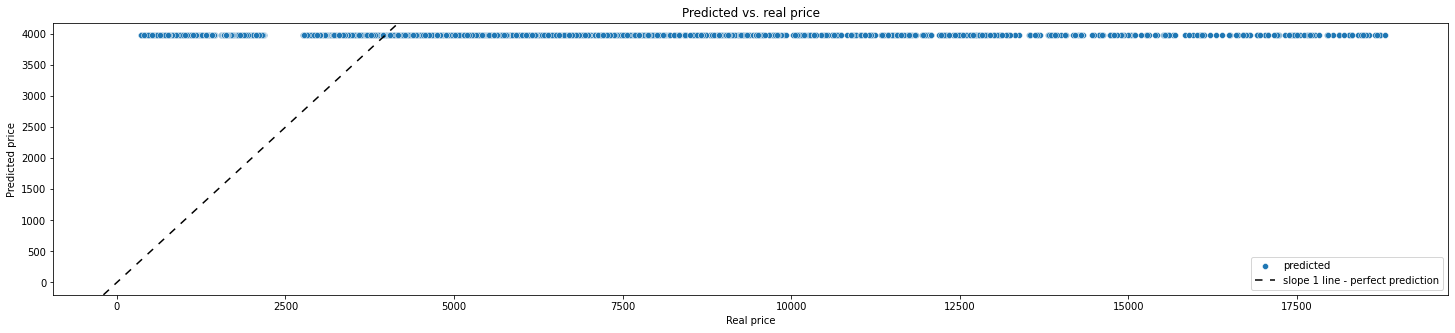

In [43]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)
model_metrics['naive_model']= metrics(dummy_regr)
print(metrics(dummy_regr))
plot_result(dummy_regr)

##Linear Regression

{'MSE': 1019395.52, 'MRSE': 1009.65, 'MAE': 674.53, 'MAPE': 16.82, 'r2': 0.94}


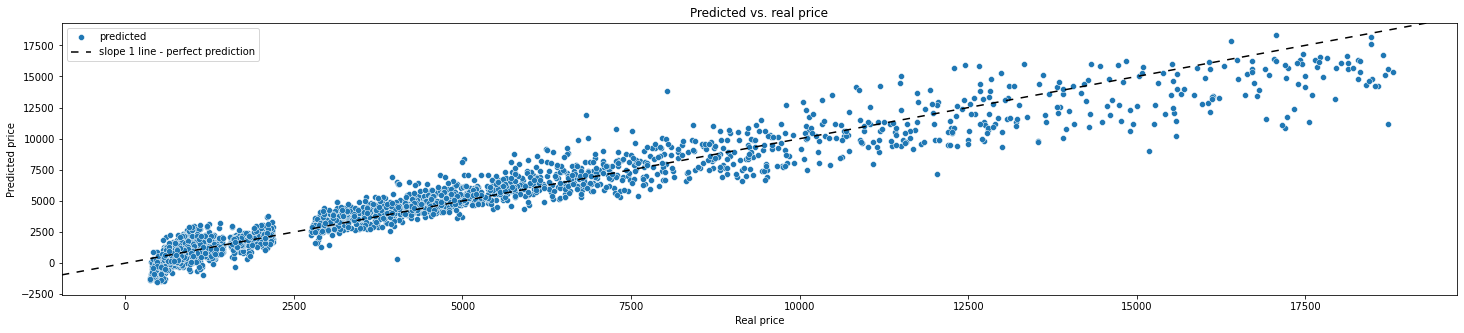

In [44]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
model_metrics['Linear_regression'] = metrics(model_lr)
print(metrics(model_lr))
plot_result(model_lr)

##Random Forest

{'MSE': 444354.32, 'MRSE': 666.6, 'MAE': 354.2, 'MAPE': 8.83, 'r2': 0.97}


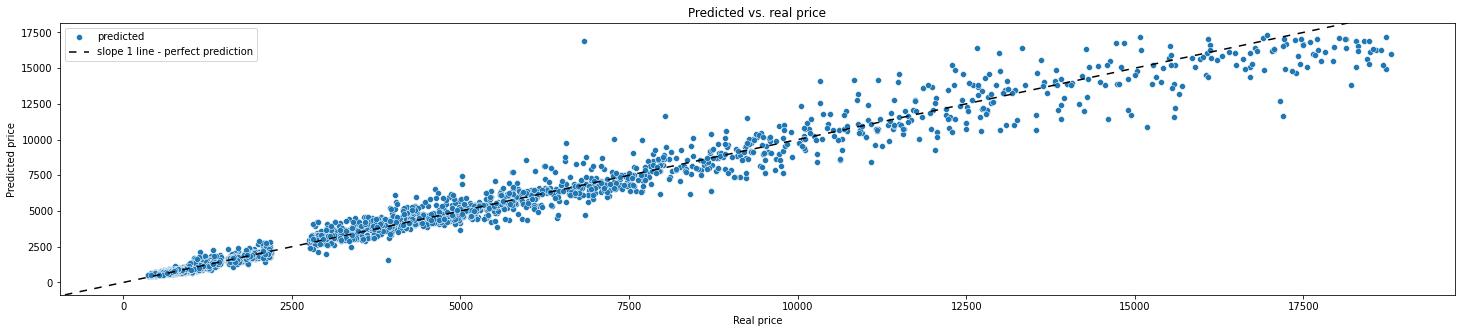

In [45]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
model_rf.fit(X_train, y_train)
model_metrics['Random_forest'] = metrics(model_rf)
print(metrics(model_rf))
plot_result(model_rf)

##XGBoost

{'MSE': 406222.42, 'MRSE': 637.36, 'MAE': 322.6, 'MAPE': 8.04, 'r2': 0.98}


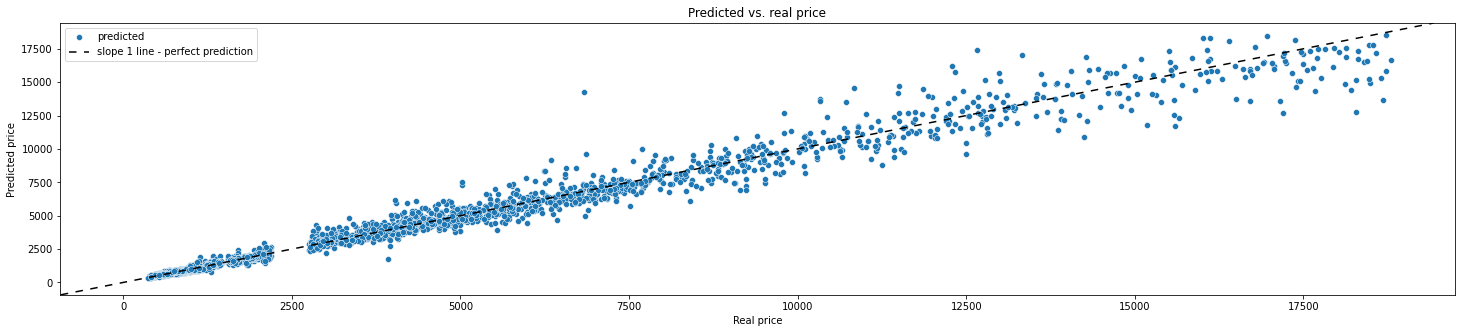

In [46]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
model_metrics['XGBoost'] = metrics(model_xgb)
print(metrics(model_xgb))
plot_result(model_xgb)

##LightGBM


{'MSE': 351107.22, 'MRSE': 592.54, 'MAE': 314.88, 'MAPE': 7.85, 'r2': 0.98}


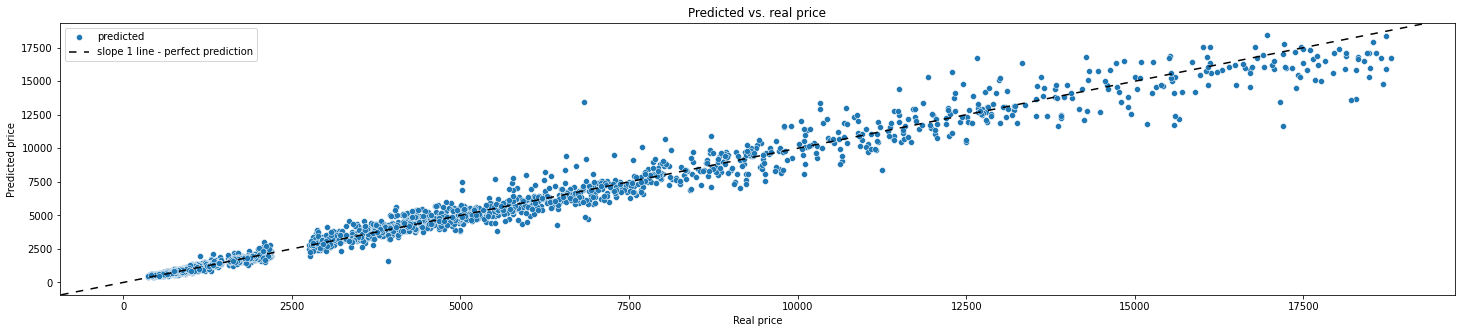

In [47]:
model_ltb = ltb.LGBMRegressor()
model_ltb.fit(X_train, y_train)
model_metrics['LightGBM'] = metrics(model_ltb)
print(metrics(model_ltb))
plot_result(model_ltb)

We can see the features importances for the model:

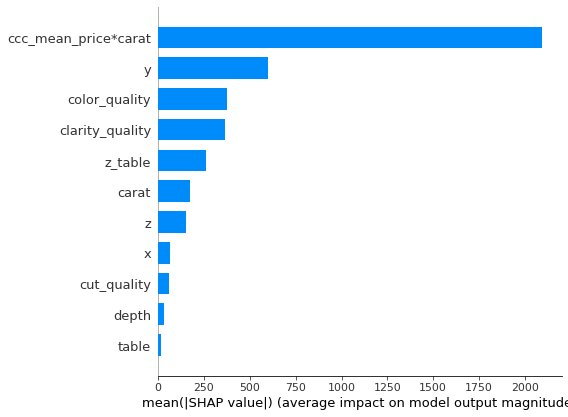

In [48]:
explainer = shap.TreeExplainer(model_ltb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=X_test.columns.tolist())

#MODELS OVERVIEW

In [49]:
models_df = pd.DataFrame(model_metrics)
models_df

naive_model  Linear_regression  Random_forest    XGBoost   LightGBM
MSE   16580446.58         1019395.52      444354.32  406222.42  351107.22
MRSE      4071.91            1009.65         666.60     637.36     592.54
MAE       3104.28             674.53         354.20     322.60     314.88
MAPE        77.41              16.82           8.83       8.04       7.85
r2          -0.00               0.94           0.97       0.98       0.98

We can see that LightGBM and XGBoost are the models with lowest MAPE, therefore, the most suited models for price estimative. However, LightGBM is faster to run in bigger datasets.

We can see that the errors are higher for high priced diamonds, which was expected, since we had less samples for data trainning.

We could improve the model, running an optimization on LightGBM parameters.

#Best Model Tuning

[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fract

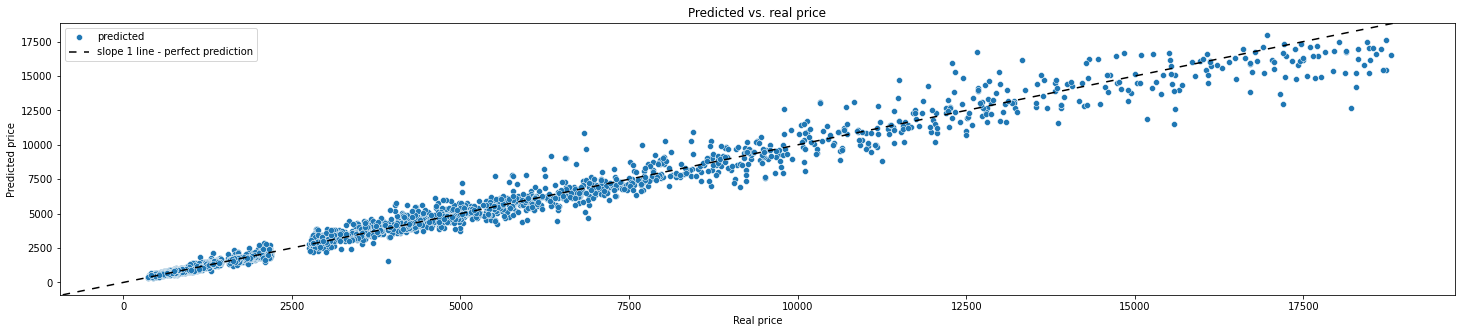

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.5, max_depth=8,
              min_data_in_leaf=10, num_leaves=20, random_strength=0.5,
              reg_lambda=5)


In [50]:
# Define hyperparameters to tune and their possible ranges
param_dist = {'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5, 1],
              'max_depth': [2, 5, 8, 12, 15],
              'num_leaves': [2, 10, 20, 35, 50],
              'reg_lambda': [5, 10, 15, 20, 30, 40, 50],
              'random_strength': [0.5, 0.75, 1, 1.25, 1.50, 1.75, 2],
              'min_data_in_leaf': [2, 10, 15, 25, 30],
              'feature_fraction': [0.5, 0.7, 0.9, 1],
              'bagging_fraction': [0.5, 0.7, 0.9, 1]}

# Choose a method for tuning
random_search = RandomizedSearchCV(model_ltb, param_distributions=param_dist, n_iter=100,
                                   cv=8, scoring='neg_mean_squared_error', random_state=42)

# Perform hyperparameter tuning
random_search.fit(X_train, y_train)

# Fit the model and evaluate the model
best_lgbm = random_search.best_estimator_
best_lgbm.fit(X_train, y_train)
model_metrics['LightGBM_tuned'] = metrics(best_lgbm)
print(metrics(best_lgbm))
plot_result(best_lgbm)
print(random_search.best_estimator_)

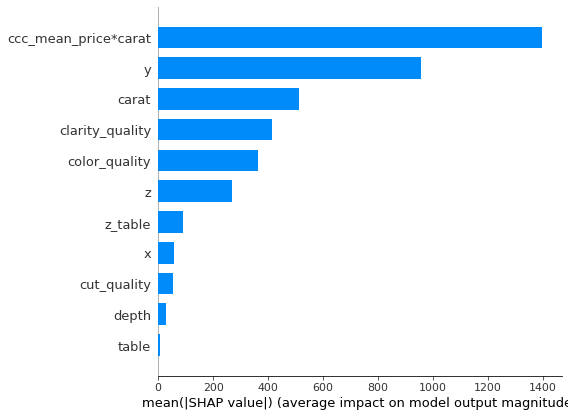

In [51]:
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=X_test.columns.tolist())

In [52]:
models_df = pd.DataFrame(model_metrics)
models_df

naive_model  Linear_regression  Random_forest    XGBoost   LightGBM  \
MSE   16580446.58         1019395.52      444354.32  406222.42  351107.22   
MRSE      4071.91            1009.65         666.60     637.36     592.54   
MAE       3104.28             674.53         354.20     322.60     314.88   
MAPE        77.41              16.82           8.83       8.04       7.85   
r2          -0.00               0.94           0.97       0.98       0.98   

      LightGBM_tuned  
MSE        338095.39  
MRSE          581.46  
MAE           314.45  
MAPE            7.84  
r2              0.98

#Config file and read_and_process function

create a Read and preprocess function to run full and/or new data and prepare to prediction.

In [53]:
config = {
    'data':{'training_file': '/content/gdrive/MyDrive/Data analysis - study/Diamonds/diamonds.csv',
            'chunksize': 10000
    },

    'parameters':{
        'max_depth': 15,
        'learning_rate':0.1,
        'num_leaves':50,
        'random_state': 42,
        'reg_lambda': 20,
        'min_data_in_leaf': 15,
        'early_stopping_rounds': 50, #Avoid overfiting
    }       
}

In [54]:
def read_and_preprocess(config=config, filename=None):
  if filename==None:
    filename = config['data']['training_file']
  chunksize = config['data']['chunksize']
  with open(filename, 'r') as f:
    n_chunks = int((sum(1 for row in f))/chunksize)
    print('Number of chunks = ', n_chunks)
    df_iterator = pd.read_csv(filename, chunksize=chunksize)
    df = pd.DataFrame()
   
    
  for chunk in tqdm(df_iterator, total=(n_chunks)):
    min = 1
    max = 99
    x_min = np.percentile(chunk['x'], min)
    x_max = np.percentile(chunk['x'], max)
    y_min = np.percentile(chunk['y'], min)
    y_max = np.percentile(chunk['y'], max)
    z_min = np.percentile(chunk['z'], min)
    z_max = np.percentile(chunk['z'], max)

    chunk=chunk.drop(chunk[(chunk['x'] > x_max)].index)
    chunk=chunk.drop(chunk[(chunk['x'] < x_min)].index)
    chunk=chunk.drop(chunk[(chunk['y'] > y_max)].index)
    chunk=chunk.drop(chunk[(chunk['y'] < y_min)].index)
    chunk=chunk.drop(chunk[(chunk['z'] > z_max)].index)
    chunk=chunk.drop(chunk[(chunk['z'] < z_min)].index)
    chunk.reset_index()

    chunk['cut_quality'] = 0
    for index, row in tqdm(chunk.iterrows()):
      if row['cut'] == 'Fair':
        quality = 1
      elif row['cut'] == 'Good':
        quality = 2
      elif row['cut'] == 'Very Good':
        quality = 3
      elif row['cut'] == 'Premium':
        quality = 4
      else:
        quality = 5
      chunk.at[index, 'cut_quality'] = quality
        
    chunk['clarity_quality'] = 0
    for index, row in tqdm(chunk.iterrows()):
      if row['clarity'] == 'I1':
        quality = 1
      elif row['clarity'] == 'SI2':
        quality = 2
      elif row['clarity'] == 'SI1':
        quality = 3
      elif row['clarity'] == 'VS2':
        quality = 4
      elif row['clarity'] == 'VS1':
        quality = 5
      elif row['clarity'] == 'VVS2':
        quality = 6
      elif row['clarity'] == 'VVS1':
        quality = 7
      else:
        quality = 8
      chunk.at[index, 'clarity_quality'] = quality
    chunk = chunk.drop(['cut', 'clarity'], axis='columns')
    def price_carat_color_and_clarity (color_type, clarity_type):
      new_df = chunk.query(f'color == "{color_type}"')
      new_df2 = new_df.query(f'clarity_quality == {clarity_type}')
      price_carat_color_clarity = round((new_df2['price'].sum())/new_df2['carat'].sum(), 2)
      return(price_carat_color_clarity)

    chunk['price/carat/color/clarity'] = chunk.apply(lambda row: price_carat_color_and_clarity(color_type=row['color'], clarity_type=row['clarity_quality']), axis=1)
    chunk['ccc_mean_price*carat'] = chunk['carat']*chunk['price/carat/color/clarity']
    chunk = chunk.drop(['price/carat/color/clarity'], axis='columns')

    chunk['z_table'] = chunk['z']/chunk['table']

    chunk['color_quality'] = 0
    for index, row in tqdm(chunk.iterrows()):
      if row['color'] == 'J':
        quality = 1
      elif row['color'] == 'I':
        quality = 2
      elif row['color'] == 'H':
        quality = 3
      elif row['color'] == 'G':
        quality = 4
      elif row['color'] == 'F':
        quality = 5
      elif row['color'] == 'E':
        quality = 6
      elif row['color'] == 'D':
        quality = 7

      chunk.at[index, 'color_quality'] = quality
    chunk = chunk.drop(['color'], axis='columns')

    chunk = chunk.reset_index(drop=True)

    df=  pd.concat([df, chunk])
  df = df.drop(df.columns[0], axis='columns')
  return df.reset_index(drop=True)

In [55]:
df1 = read_and_preprocess()

Number of chunks =  5


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1801it [00:00, 18005.90it/s]
3602it [00:00, 16982.49it/s]
5481it [00:00, 17779.87it/s]
7330it [00:00, 18052.89it/s]
9718it [00:00, 17723.24it/s]

0it [00:00, ?it/s]
1607it [00:00, 16064.42it/s]
3230it [00:00, 16159.60it/s]
5084it [00:00, 17242.03it/s]
6917it [00:00, 17671.08it/s]
9718it [00:00, 17196.02it/s]

0it [00:00, ?it/s]
1096it [00:00, 10958.55it/s]
2192it [00:00, 10953.00it/s]
3288it [00:00, 10486.86it/s]
4339it [00:00, 10011.51it/s]
5380it [00:00, 10148.19it/s]
6398it [00:00, 10146.23it/s]
7415it [00:00, 10113.58it/s]
8493it [00:00, 10319.35it/s]
9718it [00:00, 10307.89it/s]
 20%|██        | 1/5 [00:38<02:35, 38.79s/it]
0it [00:00, ?it/s]
1145it [00:00, 11448.86it/s]
2290it [00:00, 11174.39it/s]
3408it [00:00, 10982.95it/s]
4528it [00:00, 11065.11it/s]
5635it [00:00, 10281.18it/s]
6751it [00:00, 10561.09it/s]
7836it [00:00, 10649.18it/s]
9743it [00:00, 11084.82it/s]

0it [00:00, ?it/s]
1850it [00:00, 18496.80it/s]
3700it

Train the best model with full data

{'MSE': 227206.78, 'MRSE': 476.66, 'MAE': 243.81, 'MAPE': 6.22, 'r2': 0.99}


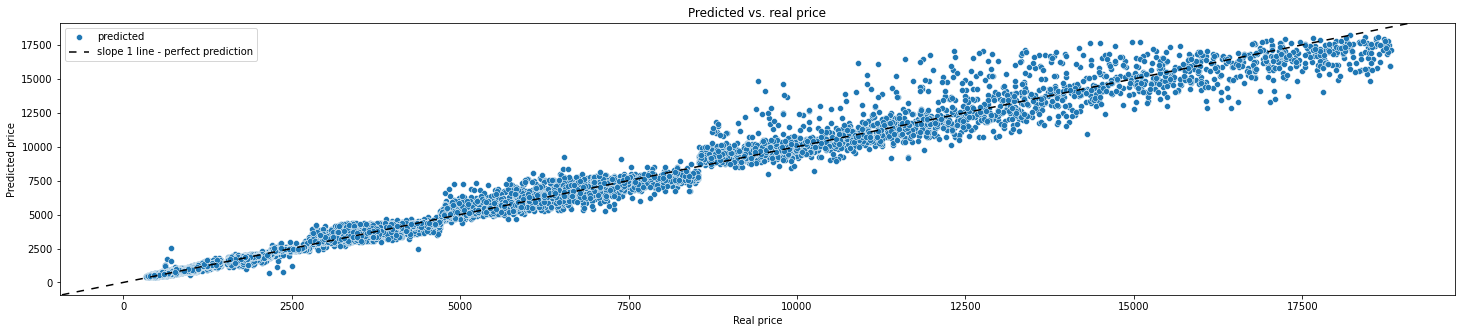

In [56]:
x = df1.drop(['price'], axis = 1)
y = df1['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=44)

model_ltb_best = ltb.LGBMRegressor(
    max_depth=config['parameters']['max_depth'],
    learning_rate=config['parameters']['learning_rate'],
    num_leaves=config['parameters']['num_leaves'],
    random_state=config['parameters']['random_state'],
    reg_lambda=config['parameters']['reg_lambda'],
    min_child_samples=config['parameters']['min_data_in_leaf'], 
)
model_ltb_best.fit(X_train, y_train)
model_metrics['LightGBM_best_fullData'] = metrics(model_ltb_best)
print(metrics(model_ltb_best))
plot_result(model_ltb_best)

In [57]:
models_df = pd.DataFrame(model_metrics)
models_df

naive_model  Linear_regression  Random_forest    XGBoost   LightGBM  \
MSE   16580446.58         1019395.52      444354.32  406222.42  351107.22   
MRSE      4071.91            1009.65         666.60     637.36     592.54   
MAE       3104.28             674.53         354.20     322.60     314.88   
MAPE        77.41              16.82           8.83       8.04       7.85   
r2          -0.00               0.94           0.97       0.98       0.98   

      LightGBM_tuned  LightGBM_best_fullData  
MSE        338095.39               227206.78  
MRSE          581.46                  476.66  
MAE           314.45                  243.81  
MAPE            7.84                    6.22  
r2              0.98                    0.99

In [58]:
#saving the model:
import pickle
filename = "Diamonds_model_VF.pkl"
with open(filename, 'wb') as file:
  pickle.dump(model_ltb_best, file)

In [59]:
#for loading the model in the future, we can use:

with open ('Diamonds_model_VF.pkl', 'rb') as f:
  model = pickle.load(f)

#CONCLUSION

The fitted model with the full data presented a MAPE of 6.22%. 
The value is good compared to naive and simple linear models, however, it can be enhanced with more data (specially for high price diamonds), and more informations, such as the format, origin, and company selling the products.